In [23]:
import nocd
from nocd.utils import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from nocd.nn import models_deep
from nocd.utils import to_sparse_tensor
from cdlib import evaluation
from sklearn.preprocessing import normalize
import networkx as nx

%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [24]:
def mod_overlap(Z, G_w, thresh=0.5):
    
    from cdlib import NodeClustering
    Z_pred = Z.cpu().detach().numpy() > thresh
    
    

# communities = [[1,2,3], [4,5,6], [7,8,9,10,11]]
    communities = coms_matrix_to_list(Z_pred)
#     print(communities)
    new_com = []
    for ls in communities:
        if(len(ls)==0):
            continue
        
        new_com.append(ls)
#     G_w =  nx.from_numpy_matrix(np.matrix(A_w), create_using=nx.DiGraph)
   


    coms = NodeClustering(new_com, G_w)

    # from cdlib import algorithms
    # import networkx as nx
    # G = nx.karate_club_graph()
    # coms = algorithms.danmf(G)
    
    mod = evaluation.modularity_overlap(G_w, coms)
#     print("mod: ", mod)

    return mod.score

# Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `scipy.sparse.csr_matrix` of size `[N, D]`
 - `Z_gt` (binary community affiliation matrix) is a `np.ndarray` of size `[N, K]`

In [25]:
# loader = nocd.data.load_dataset('data/facebook_ego/fb_348.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_414.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_686.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_698.npz')
# loader = nocd.data.load_dataset('data/facebook_ego/fb_1684.npz')
loader = nocd.data.load_dataset('data/facebook_ego/fb_1912.npz')



# loader = nocd.data.load_dataset('data/mag_eng.npz')
A, X, Z_gt = loader['A'], loader['X'], loader['Z']
orG = nx.from_numpy_matrix(A.toarray())
# _, G = nocd.nn.models_deep.augment_graph_neighbors_with_degree(A)
N, K = Z_gt.shape


In [26]:
'''
We generate hybrid graphs which real world graphs with imputated weight. 
Weights are imputation based on the assumption that 
To nodes sharing more communities would have higher weight. 
Base Idea: for each edge if two nodes share a community add 1 to the weight:
'''
# A_w = nx.to_scipy_sparse_matrix(G_w,format='csr')
# G_w =  nx.from_numpy_matrix(A_w.toarray(), create_using=nx.Graph)

import networkx as nx

def get_num_shared_community(u,v, Z, K):
    count = 0
    for k in range(K):
        if(Z[u][k]>0 and Z[v][k]>0):
            count +=1
            
    return count


def weight_imputation(A, Z_gt):
    Gw = nx.from_numpy_matrix(A, create_using = nx.Graph)
    Z = Z_gt
    N, K = Z_gt.shape
    
    edges = Gw.edges()
    
    count = 0
    for pair in edges:
        u, v = pair
        
        Gw[v][u]['weight']=Gw[u][v]['weight'] = int(get_num_shared_community(u,v, Z, K ) + 1)
        if(Gw[v][u]['weight']==1):
            count+=1
            
    print("non sharing edges: ", count)
    print("in total edges: ", Gw.number_of_edges())
        
    
    return Gw
        
        
        
        
        
Gw = weight_imputation(A, Z_gt) 
# orG = Gw
Aw = nx.to_scipy_sparse_matrix(Gw,format='csr')
# print(Aw[6])
    
    

non sharing edges:  4915
in total edges:  30025


In [27]:
max_weight = 0
for edge in Gw.edges(data=True):
    _,_, weight = edge
    max_weight = max(weight['weight'], max_weight)
    
print("max weight: ", max_weight)

max weight:  4


In [28]:
_, Gaug = nocd.nn.models_deep.augment_graph_weighted_facebook_random(A, k=2, G=Gw)

print("old edges total: ", Gw.number_of_edges())
print("new edges total: ", Gaug.number_of_edges())
G = Gaug

100%|██████████| 755/755 [00:06<00:00, 110.55it/s]


old edges total:  30025
new edges total:  62733


In [29]:
# X = sp.csr_matrix(np.eye(N,dtype=np.int32)) #NOCD-G

Define the hyperparameters

In [30]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0   # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)
layers_arr=[2,3,4,5,6,7]
# layers_arr=[2,3,5,7, 10,15,30,40,50]
print('N, edges: ', N, A.nnz)

# top_n = max_epochs//100
top_n = 5

N, edges:  755 60050


Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

Define the GNN model

In [31]:
def get_nmi(Z, thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

### Unsupervised Depth Search


In [32]:

best_Z = 0
# best_nmi = 0
best_loss = 99999999
best_layer = 2
best_mod = -9999999

best_avg_mod = -9999999
best_avg_layer = 2

for layers in layers_arr:
    
#     weight_decay = weight_decay 
    
    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

    sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
    gnn = nocd.nn.models_deep.GCNRes(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout, layer_num=layers, g=G, d=2).cuda()
    adj_norm = gnn.normalize_adj(A)
    decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
    opt = torch.optim.Adam(gnn.parameters(), lr=lr)

    val_loss = np.inf
    validation_fn = lambda: val_loss
    early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
    model_saver = nocd.train.ModelSaver(gnn)
    
    avg_mod = 0
    
    all_mod = []

    for epoch, batch in enumerate(sampler):
        if epoch > max_epochs:
            break
        if (epoch+1) % 25 == 0:
            with torch.no_grad():
                gnn.eval()
                # Compute validation loss
                Z = F.relu(gnn(x_norm))
                val_loss = decoder.loss_full(Z, A)
                val=get_nmi(Z)
                mod = mod_overlap(Z,orG)
                
                all_mod.append(mod)
                avg_mod += mod
#                 if(val_loss<best_loss):
#                     best_loss = val_loss
#                     best_nmi =val
#                     best_Z = Z.detach().clone()
#                     best_layer = layers

                if(mod>best_mod):
                    best_mod = mod
                    best_Z = Z.detach().clone()
                    best_layer = layers
                    best_nmi = val
                    
                print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {val:.2f}, \
                      mod ={mod} layer={layers}')

                # Check if it's time for early stopping / to save the model
                early_stopping.next_step()
                if early_stopping.should_save():
                    model_saver.save()
                if early_stopping.should_stop():
                    print(f'Breaking due to early stopping at epoch {epoch}')
                    break

        # Training step
        gnn.train()
        opt.zero_grad()
        Z = F.relu(gnn(x_norm))
        ones_idx, zeros_idx = batch
        if stochastic_loss:
            # loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
#             loss = decoder.loss_batch_triangles(Z, ones_idx, zeros_idx)
#             print(f'Epoch {epoch:4d}, triangle loss = {loss:.4f}, nmi = {get_nmi(Z):.2f}')
            loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
#             print(f'Epoh {epoch:4d}, edge loss = {loss1:.4f}, nmi = {get_nmi(Z):.2f}')
#             loss =  loss +  loss1
            # loss = (1/(0.01*epoch+1))* loss + loss1
#             loss = 0.25 * loss + 0.75 * loss1

#             print(f'Epoch {epoch:4d}, total loss = {loss:.4f}, nmi = {get_nmi(Z):.2f}')
            # print(f'Epoch {epoch:4d}, (25, 75) total loss = {loss:.4f}, nmi = {get_nmi():.2f}')
        else:
            loss = decoder.loss_full(Z, A)
        loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
        loss.backward()
        opt.step()
        
    all_mod.sort(reverse=True)
    
#     top_n = epoch//100
    
    print("epoch: ",epoch, " top_n: ", top_n)
    
    avg_mod = sum(all_mod[:top_n])/top_n
    print("top 5: ", all_mod[:top_n])
    print("avg mod:", avg_mod, "at layer: ", layers)
    if(avg_mod>best_avg_mod):
        best_avg_mod = avg_mod
        best_avg_layer = layers
    
#     Z = F.relu(gnn(x_norm))
#     val=get_nmi(Z)
#     if(val> best_nmi):
#         best_nmi = val
#         best_Z = Z.detach().clone()
#         best_layer = layers
print(f'stoped training, best nmi={best_nmi}, best_mod={best_mod},  at layer={best_layer}')
print(f'best avg mod={best_avg_mod}, best avg layer={best_avg_layer}')



Epoch   24, loss.full = 0.3128, nmi = 0.28,                       mod =0.031075094565809338 layer=2
Epoch   49, loss.full = 0.2414, nmi = 0.31,                       mod =0.028506196407383326 layer=2
Epoch   74, loss.full = 0.2248, nmi = 0.35,                       mod =0.0246359950165909 layer=2
Epoch   99, loss.full = 0.2167, nmi = 0.38,                       mod =0.03325666228631198 layer=2
Epoch  124, loss.full = 0.2116, nmi = 0.38,                       mod =0.04152431378732687 layer=2
Epoch  149, loss.full = 0.2079, nmi = 0.38,                       mod =0.04857693334334958 layer=2
Epoch  174, loss.full = 0.2045, nmi = 0.38,                       mod =0.04598536223205122 layer=2
Epoch  199, loss.full = 0.2018, nmi = 0.39,                       mod =0.04424519167342628 layer=2
Epoch  224, loss.full = 0.1994, nmi = 0.38,                       mod =0.03725696514894692 layer=2
Epoch  249, loss.full = 0.1971, nmi = 0.39,                       mod =0.022958393631859537 layer=2
Epoch  2

Epoch  474, loss.full = 0.2156, nmi = 0.39,                       mod =0.09079190416315751 layer=5
Epoch  499, loss.full = 0.2148, nmi = 0.39,                       mod =0.09771475049912987 layer=5
epoch:  501  top_n:  5
top 5:  [0.11808572202901348, 0.09771475049912987, 0.09740955744196514, 0.09079190416315751, 0.08974369002332296]
avg mod: 0.09874912483131779 at layer:  5
Epoch   24, loss.full = 0.2545, nmi = 0.38,                       mod =0.034185269580828924 layer=6
Epoch   49, loss.full = 0.2354, nmi = 0.41,                       mod =0.05368984208785204 layer=6
Epoch   74, loss.full = 0.2316, nmi = 0.40,                       mod =0.05725350741336091 layer=6
Epoch   99, loss.full = 0.2292, nmi = 0.41,                       mod =0.0608095406961898 layer=6
Epoch  124, loss.full = 0.2266, nmi = 0.42,                       mod =0.10024541670087293 layer=6
Epoch  149, loss.full = 0.2242, nmi = 0.40,                       mod =0.07808350049568208 layer=6
Epoch  174, loss.full = 0.223

stoped training, best nmi=0.4083269316443058, at layer=7


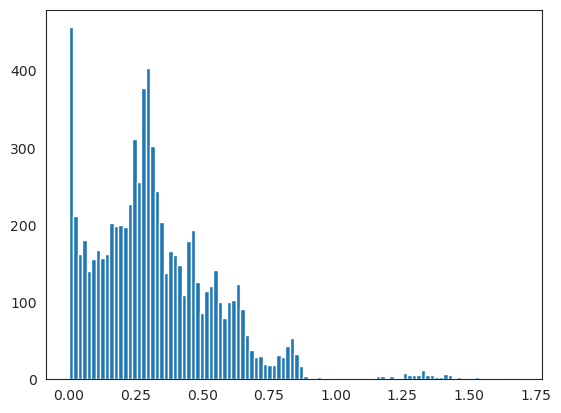

In [33]:
print(f'stoped training, best nmi={best_nmi}, at layer={best_layer}')

plt.hist(best_Z[best_Z > 0].cpu().detach().numpy(), 100);

In [34]:
threshs=[ 0.125, 0.3,0.35, 0.4, 0.5, 0.75, 0.80]
best_mod = -99999
for thresh in threshs:

    
    Z_pred = best_Z.cpu().detach().numpy() > thresh
    mod = mod_overlap(best_Z, orG, thresh)
#     model_saver.restore()
    print(f'Final nmi = {get_nmi(best_Z,thresh):.3f}, \
          final_mod={mod} for thresh= {thresh}')
    
    if(mod>best_mod):
        best_mod = mod
        best_thresh = thresh
        
print(f'best_mod={best_mod}, best_nmi={best_nmi}')
    

Final nmi = 0.321,           final_mod=0.05983367759956587 for thresh= 0.125
Final nmi = 0.346,           final_mod=0.07309201692218321 for thresh= 0.3
Final nmi = 0.368,           final_mod=0.0845346890100842 for thresh= 0.35
Final nmi = 0.377,           final_mod=0.1081061139485379 for thresh= 0.4
Final nmi = 0.408,           final_mod=0.1468064338936366 for thresh= 0.5
Final nmi = 0.150,           final_mod=-0.006823482195116415 for thresh= 0.75
Final nmi = 0.123,           final_mod=0.06416585434251129 for thresh= 0.8
best_mod=0.1468064338936366, best_nmi=0.4083269316443058


In [35]:

hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0       # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500       # number of epochs to train
display_step = 5       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000   


import numpy as np
niters = 50

### Evaluating the model on the best depth

In [36]:

best_thresh=0.5
# # best_thresh = 0.8
best_layer = best_avg_layer
print("best thresh: ", best_thresh)
print('best_layer: ', best_layer)
nmi_arr = [] 
mod_arr = []
nmi_arr_last = [ ]
for t in range(niters):
    best_nmi=0
    best_mod = 0
#     _, G = nocd.nn.models_deep.augment_graph_neighbors_with_degree(A)
    _, G = nocd.nn.models_deep.augment_graph_weighted_facebook_random(A, k=2, G=Gw)


    
    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

    sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
    gnn = nocd.nn.models_deep.GCNRes(x_norm.shape[1], hidden_sizes, K, 
                                     batch_norm=batch_norm, dropout=dropout, layer_num=best_layer, g=G, d=2).cuda()
    adj_norm = gnn.normalize_adj(A)
    decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
    opt = torch.optim.Adam(gnn.parameters(), lr=lr)

    val_loss = np.inf
    validation_fn = lambda: val_loss
    early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
    model_saver = nocd.train.ModelSaver(gnn)
    
    
    for epoch, batch in enumerate(sampler):
        if epoch > max_epochs:
            break
        if epoch % 25 == 0:
            with torch.no_grad():
                gnn.eval()
                # Compute validation loss
                Z = F.relu(gnn(x_norm))
                val_loss = decoder.loss_full(Z, A)
                nmi=get_nmi(Z,best_thresh)
                mod =  mod_overlap(Z,orG, best_thresh)
                if(mod> best_mod):
                    best_mod = mod
                    best_nmi = nmi
                    best_Z = Z.detach().clone()
                    
                    
                print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {nmi:.2f}, mod={mod}')

                # Check if it's time for early stopping / to save the model
                early_stopping.next_step()
                if early_stopping.should_save():
                    model_saver.save()
                if early_stopping.should_stop():
                    print(f'Breaking due to early stopping at epoch {epoch}')
                    break

        # Training step
        gnn.train()
        opt.zero_grad()
        Z = F.relu(gnn(x_norm))
        ones_idx, zeros_idx = batch
        if stochastic_loss:
           # loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
#             loss = decoder.loss_batch_triangles(Z, ones_idx, zeros_idx)
#             print(f'Epoch {epoch:4d}, triangle loss = {loss:.4f}, nmi = {get_nmi(Z):.2f}')
            loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
#             print(f'Epoch {epoch:4d}, edge loss = {loss1:.4f}, nmi = {get_nmi(Z):.2f}')
#             loss =  loss +  loss1
            # loss = (1/(0.01*epoch+1))* loss + loss1
#             loss = 0.25 * loss + 0.75 * loss1

#             print(f'Epoch {epoch:4d}, total loss = {loss:.4f}, nmi = {get_nmi(Z):.2f}')
            # print(f'Epoch {epoch:4d}, (25, 75) total loss = {loss:.4f}, nmi = {get_nmi():.2f}')
        else:
            loss = decoder.loss_full(Z, A)
        loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
        loss.backward()
        opt.step()
      
    Z = F.relu(gnn(x_norm))
#     val_loss = decoder.loss_full(Z, A)
    val=get_nmi(Z,best_thresh)
#     best_nmi = val
    nmi_arr.append(best_nmi)
    mod_arr.append(best_mod)
    nmi_arr_last.append(val) 
    print("best nmi: ", best_nmi)
    print("best mod: ", best_mod)
    print("last nmi: ", val)
    
    print('iter: ',t)

print("Done")



best thresh:  0.5
best_layer:  6


100%|██████████| 755/755 [00:17<00:00, 42.48it/s]


Epoch    0, loss.full = 1.3060, nmi = 0.24, mod=0.02096390726007789
Epoch   25, loss.full = 0.2564, nmi = 0.36, mod=0.03545964279796094
Epoch   50, loss.full = 0.2331, nmi = 0.35, mod=0.031015053981869902
Epoch   75, loss.full = 0.2287, nmi = 0.34, mod=0.03303771217307119
Epoch  100, loss.full = 0.2261, nmi = 0.35, mod=0.05408858396846042
Epoch  125, loss.full = 0.2247, nmi = 0.34, mod=0.047330342526068346
Epoch  150, loss.full = 0.2227, nmi = 0.35, mod=0.0728390170298913
Epoch  175, loss.full = 0.2213, nmi = 0.37, mod=0.07927693996312095
Epoch  200, loss.full = 0.2206, nmi = 0.37, mod=0.07828873992431995
Epoch  225, loss.full = 0.2194, nmi = 0.39, mod=0.0826094091839845
Epoch  250, loss.full = 0.2182, nmi = 0.36, mod=0.07886508560210721
Epoch  275, loss.full = 0.2183, nmi = 0.38, mod=0.08584525312386686
Epoch  300, loss.full = 0.2170, nmi = 0.39, mod=0.10122102948621087
Epoch  325, loss.full = 0.2208, nmi = 0.39, mod=0.10892517918203928
Epoch  350, loss.full = 0.2168, nmi = 0.36, mod=

100%|██████████| 755/755 [00:12<00:00, 62.00it/s]


Epoch    0, loss.full = 1.0729, nmi = 0.23, mod=0.014510114242713429
Epoch   25, loss.full = 0.2415, nmi = 0.38, mod=0.05977983009214465
Epoch   50, loss.full = 0.2320, nmi = 0.39, mod=0.06012291092473139
Epoch   75, loss.full = 0.2285, nmi = 0.39, mod=0.04453349987759294
Epoch  100, loss.full = 0.2256, nmi = 0.37, mod=0.08735303605315616
Epoch  125, loss.full = 0.2229, nmi = 0.37, mod=0.06332844176307144
Epoch  150, loss.full = 0.2210, nmi = 0.40, mod=0.05007771036975289
Epoch  175, loss.full = 0.2206, nmi = 0.42, mod=0.08304111105175802
Epoch  200, loss.full = 0.2192, nmi = 0.42, mod=0.09230987756382031
Epoch  225, loss.full = 0.2187, nmi = 0.41, mod=0.11758996268173959
Epoch  250, loss.full = 0.2174, nmi = 0.41, mod=0.14293018205320884
Epoch  275, loss.full = 0.2185, nmi = 0.41, mod=0.1139770024776847
Epoch  300, loss.full = 0.2164, nmi = 0.41, mod=0.07399695570378388
Epoch  325, loss.full = 0.2156, nmi = 0.41, mod=0.0928336834171569
Epoch  350, loss.full = 0.2153, nmi = 0.41, mod=0

100%|██████████| 755/755 [00:03<00:00, 226.28it/s]


Epoch    0, loss.full = 1.2776, nmi = 0.23, mod=0.017614991114564892
Epoch   25, loss.full = 0.2491, nmi = 0.37, mod=0.036519023396449746
Epoch   50, loss.full = 0.2322, nmi = 0.39, mod=0.03717700572846974
Epoch   75, loss.full = 0.2292, nmi = 0.38, mod=0.06522245394298493
Epoch  100, loss.full = 0.2269, nmi = 0.37, mod=0.06595230370191793
Epoch  125, loss.full = 0.2235, nmi = 0.37, mod=0.06774680152516432
Epoch  150, loss.full = 0.2214, nmi = 0.38, mod=0.0639570308603377
Epoch  175, loss.full = 0.2198, nmi = 0.39, mod=0.0820204903257799
Epoch  200, loss.full = 0.2191, nmi = 0.39, mod=0.07449316254673048
Epoch  225, loss.full = 0.2184, nmi = 0.38, mod=0.08271250102941412
Epoch  250, loss.full = 0.2178, nmi = 0.37, mod=0.0903334576324537
Epoch  275, loss.full = 0.2185, nmi = 0.39, mod=0.09100623937517857
Epoch  300, loss.full = 0.2167, nmi = 0.38, mod=0.09332863727557922
Epoch  325, loss.full = 0.2160, nmi = 0.38, mod=0.08988071194278385
Epoch  350, loss.full = 0.2164, nmi = 0.39, mod=0

100%|██████████| 755/755 [00:07<00:00, 97.78it/s] 


Epoch    0, loss.full = 1.3431, nmi = 0.25, mod=0.017058337974465803
Epoch   25, loss.full = 0.2467, nmi = 0.37, mod=0.054894037185547764
Epoch   50, loss.full = 0.2316, nmi = 0.37, mod=0.051337801478453036
Epoch   75, loss.full = 0.2287, nmi = 0.37, mod=0.06673314443490762
Epoch  100, loss.full = 0.2262, nmi = 0.38, mod=0.06941684260678888
Epoch  125, loss.full = 0.2243, nmi = 0.37, mod=0.07103685119529288
Epoch  150, loss.full = 0.2223, nmi = 0.37, mod=0.058230512956927605
Epoch  175, loss.full = 0.2230, nmi = 0.39, mod=0.05401706662586579
Epoch  200, loss.full = 0.2208, nmi = 0.39, mod=0.057682270279143695
Epoch  225, loss.full = 0.2199, nmi = 0.40, mod=0.052986474085019365
Epoch  250, loss.full = 0.2193, nmi = 0.40, mod=0.09358401291591677
Epoch  275, loss.full = 0.2186, nmi = 0.41, mod=0.1274812663384102
Epoch  300, loss.full = 0.2181, nmi = 0.41, mod=0.09770432584840573
Epoch  325, loss.full = 0.2174, nmi = 0.42, mod=0.135222494962616
Epoch  350, loss.full = 0.2198, nmi = 0.41, m

100%|██████████| 755/755 [00:16<00:00, 46.33it/s]


Epoch    0, loss.full = 1.3620, nmi = 0.26, mod=0.020415466274167758
Epoch   25, loss.full = 0.2471, nmi = 0.39, mod=0.03650435736775769
Epoch   50, loss.full = 0.2343, nmi = 0.39, mod=0.038693837229474996
Epoch   75, loss.full = 0.2303, nmi = 0.39, mod=0.04706823121566673
Epoch  100, loss.full = 0.2277, nmi = 0.40, mod=0.075145045863764
Epoch  125, loss.full = 0.2260, nmi = 0.40, mod=0.0509301984622807
Epoch  150, loss.full = 0.2244, nmi = 0.38, mod=0.05238920257301379
Epoch  175, loss.full = 0.2236, nmi = 0.41, mod=0.0768826130626418
Epoch  200, loss.full = 0.2223, nmi = 0.41, mod=0.11029432537496257
Epoch  225, loss.full = 0.2214, nmi = 0.40, mod=0.09586597791500207
Epoch  250, loss.full = 0.2211, nmi = 0.39, mod=0.06028616701458826
Epoch  275, loss.full = 0.2213, nmi = 0.42, mod=0.10353204547382877
Epoch  300, loss.full = 0.2189, nmi = 0.42, mod=0.08772770241880845
Epoch  325, loss.full = 0.2176, nmi = 0.42, mod=0.11068918074157336
Epoch  350, loss.full = 0.2175, nmi = 0.44, mod=0.

100%|██████████| 755/755 [00:13<00:00, 54.52it/s]


Epoch    0, loss.full = 1.4078, nmi = 0.27, mod=0.020643691632984667
Epoch   25, loss.full = 0.2502, nmi = 0.37, mod=0.028694906669016227
Epoch   50, loss.full = 0.2336, nmi = 0.40, mod=0.0347623608877331
Epoch   75, loss.full = 0.2296, nmi = 0.39, mod=0.057665536132653385
Epoch  100, loss.full = 0.2265, nmi = 0.39, mod=0.06402740694027
Epoch  125, loss.full = 0.2233, nmi = 0.37, mod=0.03240412627589695
Epoch  150, loss.full = 0.2222, nmi = 0.38, mod=0.04748703496440927
Epoch  175, loss.full = 0.2209, nmi = 0.38, mod=0.06198761059597998
Epoch  200, loss.full = 0.2202, nmi = 0.38, mod=0.052805171462373256
Epoch  225, loss.full = 0.2196, nmi = 0.38, mod=0.0589758553379966
Epoch  250, loss.full = 0.2193, nmi = 0.39, mod=0.07468159201647154
Epoch  275, loss.full = 0.2188, nmi = 0.38, mod=0.07879973848441468
Epoch  300, loss.full = 0.2188, nmi = 0.38, mod=0.06998322724037102
Epoch  325, loss.full = 0.2174, nmi = 0.37, mod=0.0847775692640019
Epoch  350, loss.full = 0.2174, nmi = 0.38, mod=0.

100%|██████████| 755/755 [00:10<00:00, 71.57it/s] 


Epoch    0, loss.full = 1.3388, nmi = 0.25, mod=0.020103778785244407
Epoch   25, loss.full = 0.2474, nmi = 0.37, mod=0.045597831758118455
Epoch   50, loss.full = 0.2343, nmi = 0.36, mod=0.026866444682056123
Epoch   75, loss.full = 0.2320, nmi = 0.38, mod=0.054850308694628806
Epoch  100, loss.full = 0.2302, nmi = 0.38, mod=0.03892865600444433
Epoch  125, loss.full = 0.2284, nmi = 0.41, mod=0.0825164631605014
Epoch  150, loss.full = 0.2270, nmi = 0.41, mod=0.0897683764706158
Epoch  175, loss.full = 0.2256, nmi = 0.41, mod=0.09374956604379713
Epoch  200, loss.full = 0.2243, nmi = 0.40, mod=0.07748908452012589
Epoch  225, loss.full = 0.2225, nmi = 0.40, mod=0.09892116949684567
Epoch  250, loss.full = 0.2213, nmi = 0.40, mod=0.052481563775981496
Epoch  275, loss.full = 0.2209, nmi = 0.40, mod=0.10519005411209588
Epoch  300, loss.full = 0.2199, nmi = 0.39, mod=0.08525788722402615
Epoch  325, loss.full = 0.2197, nmi = 0.39, mod=0.07780017263793455
Epoch  350, loss.full = 0.2190, nmi = 0.39, m

100%|██████████| 755/755 [00:11<00:00, 67.63it/s] 


Epoch    0, loss.full = 1.6800, nmi = 0.26, mod=0.020668123902761498
Epoch   25, loss.full = 0.2536, nmi = 0.37, mod=0.029198677183072518
Epoch   50, loss.full = 0.2344, nmi = 0.39, mod=0.056146434107365875
Epoch   75, loss.full = 0.2303, nmi = 0.37, mod=0.05178487867782463
Epoch  100, loss.full = 0.2281, nmi = 0.38, mod=0.07259058737635306
Epoch  125, loss.full = 0.2256, nmi = 0.37, mod=0.05434250363785881
Epoch  150, loss.full = 0.2238, nmi = 0.37, mod=0.07623345360136859
Epoch  175, loss.full = 0.2227, nmi = 0.38, mod=0.0682523153932451
Epoch  200, loss.full = 0.2212, nmi = 0.38, mod=0.07490445647522191
Epoch  225, loss.full = 0.2205, nmi = 0.38, mod=0.08195716729355071
Epoch  250, loss.full = 0.2197, nmi = 0.39, mod=0.08243886609158944
Epoch  275, loss.full = 0.2190, nmi = 0.41, mod=0.08672377887862451
Epoch  300, loss.full = 0.2186, nmi = 0.41, mod=0.0958402127700508
Epoch  325, loss.full = 0.2176, nmi = 0.42, mod=0.062350396477719595
Epoch  350, loss.full = 0.2178, nmi = 0.42, mo

100%|██████████| 755/755 [00:11<00:00, 64.04it/s]


Epoch    0, loss.full = 1.3090, nmi = 0.29, mod=0.016477594746898055
Epoch   25, loss.full = 0.2477, nmi = 0.38, mod=0.03810731652148212
Epoch   50, loss.full = 0.2330, nmi = 0.40, mod=0.038107611609770234
Epoch   75, loss.full = 0.2298, nmi = 0.39, mod=0.046505948184162774
Epoch  100, loss.full = 0.2274, nmi = 0.39, mod=0.042773513269248525
Epoch  125, loss.full = 0.2247, nmi = 0.42, mod=0.06758316380387817
Epoch  150, loss.full = 0.2234, nmi = 0.41, mod=0.062318050451922916
Epoch  175, loss.full = 0.2232, nmi = 0.41, mod=0.049784135848785195
Epoch  200, loss.full = 0.2208, nmi = 0.40, mod=0.07397206341311977
Epoch  225, loss.full = 0.2185, nmi = 0.40, mod=0.05848428650346006
Epoch  250, loss.full = 0.2177, nmi = 0.40, mod=0.06304775857444352
Epoch  275, loss.full = 0.2168, nmi = 0.40, mod=0.09473510962028811
Epoch  300, loss.full = 0.2153, nmi = 0.39, mod=0.09058716149154467
Epoch  325, loss.full = 0.2151, nmi = 0.39, mod=0.09640640323393677
Epoch  350, loss.full = 0.2148, nmi = 0.39

100%|██████████| 755/755 [00:11<00:00, 64.72it/s]


Epoch    0, loss.full = 1.3661, nmi = 0.25, mod=0.02137205785179891
Epoch   25, loss.full = 0.2475, nmi = 0.37, mod=0.04188770358582467
Epoch   50, loss.full = 0.2309, nmi = 0.37, mod=0.03962360233405314
Epoch   75, loss.full = 0.2262, nmi = 0.40, mod=0.0642839372872541
Epoch  100, loss.full = 0.2275, nmi = 0.38, mod=0.04060062643838018
Epoch  125, loss.full = 0.2228, nmi = 0.39, mod=0.046589325277988335
Epoch  150, loss.full = 0.2218, nmi = 0.39, mod=0.06458657372510988
Epoch  175, loss.full = 0.2212, nmi = 0.38, mod=0.06322850845009804
Epoch  200, loss.full = 0.2205, nmi = 0.39, mod=0.05859227267737031
Epoch  225, loss.full = 0.2201, nmi = 0.40, mod=0.06892886667259288
Epoch  250, loss.full = 0.2198, nmi = 0.40, mod=0.07199307477490584
Epoch  275, loss.full = 0.2191, nmi = 0.39, mod=0.07896838193575716
Epoch  300, loss.full = 0.2181, nmi = 0.39, mod=0.0717955033457223
Epoch  325, loss.full = 0.2185, nmi = 0.40, mod=0.08038558595999919
Epoch  350, loss.full = 0.2173, nmi = 0.39, mod=0

100%|██████████| 755/755 [00:10<00:00, 70.17it/s] 


Epoch    0, loss.full = 1.3069, nmi = 0.22, mod=0.022404760745686935
Epoch   25, loss.full = 0.2450, nmi = 0.35, mod=0.031842061276274355
Epoch   50, loss.full = 0.2339, nmi = 0.36, mod=0.042639285524081416
Epoch   75, loss.full = 0.2304, nmi = 0.37, mod=0.0737675728407803
Epoch  100, loss.full = 0.2280, nmi = 0.37, mod=0.0645714623027426
Epoch  125, loss.full = 0.2243, nmi = 0.38, mod=0.07367454837827035
Epoch  150, loss.full = 0.2221, nmi = 0.39, mod=0.07943716031827806
Epoch  175, loss.full = 0.2210, nmi = 0.38, mod=0.06298746853119692
Epoch  200, loss.full = 0.2204, nmi = 0.37, mod=0.07255104895328722
Epoch  225, loss.full = 0.2194, nmi = 0.39, mod=0.061946002274783966
Epoch  250, loss.full = 0.2186, nmi = 0.39, mod=0.08685564471699746
Epoch  275, loss.full = 0.2188, nmi = 0.39, mod=0.08521546636387543
Epoch  300, loss.full = 0.2175, nmi = 0.37, mod=0.06329192826652252
Epoch  325, loss.full = 0.2169, nmi = 0.39, mod=0.07448007761207234
Epoch  350, loss.full = 0.2164, nmi = 0.38, mo

100%|██████████| 755/755 [00:12<00:00, 60.53it/s]


Epoch    0, loss.full = 1.4000, nmi = 0.24, mod=0.018318998258150414
Epoch   25, loss.full = 0.2470, nmi = 0.35, mod=0.03299231963680502
Epoch   50, loss.full = 0.2328, nmi = 0.35, mod=0.04114928694943302
Epoch   75, loss.full = 0.2305, nmi = 0.37, mod=0.0464163427422715
Epoch  100, loss.full = 0.2283, nmi = 0.38, mod=0.07171397328895006
Epoch  125, loss.full = 0.2262, nmi = 0.37, mod=0.09614651240096422
Epoch  150, loss.full = 0.2248, nmi = 0.37, mod=0.06251420591823402
Epoch  175, loss.full = 0.2236, nmi = 0.37, mod=0.08674197480260798
Epoch  200, loss.full = 0.2228, nmi = 0.38, mod=0.08469197407369075
Epoch  225, loss.full = 0.2219, nmi = 0.37, mod=0.09752323740296634
Epoch  250, loss.full = 0.2201, nmi = 0.36, mod=0.0891161442834286
Epoch  275, loss.full = 0.2192, nmi = 0.36, mod=0.08428916360888666
Epoch  300, loss.full = 0.2192, nmi = 0.36, mod=0.08633180844993664
Epoch  325, loss.full = 0.2183, nmi = 0.36, mod=0.10171258017212373
Epoch  350, loss.full = 0.2170, nmi = 0.36, mod=0

100%|██████████| 755/755 [00:11<00:00, 67.38it/s] 


Epoch    0, loss.full = 1.3180, nmi = 0.27, mod=0.02083207113558764
Epoch   25, loss.full = 0.2474, nmi = 0.37, mod=0.03319298343948574
Epoch   50, loss.full = 0.2343, nmi = 0.40, mod=0.02801357059287349
Epoch   75, loss.full = 0.2315, nmi = 0.41, mod=0.07122442126159866
Epoch  100, loss.full = 0.2294, nmi = 0.39, mod=0.07427647393750403
Epoch  125, loss.full = 0.2266, nmi = 0.41, mod=0.10289943204203034
Epoch  150, loss.full = 0.2263, nmi = 0.38, mod=0.09047127020398052
Epoch  175, loss.full = 0.2245, nmi = 0.38, mod=0.09748792201573983
Epoch  200, loss.full = 0.2233, nmi = 0.38, mod=0.1266707608833541
Epoch  225, loss.full = 0.2201, nmi = 0.38, mod=0.10795541287061948
Epoch  250, loss.full = 0.2188, nmi = 0.40, mod=0.1380001553984728
Epoch  275, loss.full = 0.2184, nmi = 0.41, mod=0.11553273457447875
Epoch  300, loss.full = 0.2180, nmi = 0.41, mod=0.09352044702837255
Epoch  325, loss.full = 0.2173, nmi = 0.40, mod=0.09887338262222324
Epoch  350, loss.full = 0.2169, nmi = 0.40, mod=0.

100%|██████████| 755/755 [00:08<00:00, 92.22it/s] 


Epoch    0, loss.full = 1.3042, nmi = 0.26, mod=0.01460768050877532
Epoch   25, loss.full = 0.2518, nmi = 0.35, mod=0.03430836684414606
Epoch   50, loss.full = 0.2363, nmi = 0.38, mod=0.020927053289646065
Epoch   75, loss.full = 0.2321, nmi = 0.36, mod=0.038352052455844304
Epoch  100, loss.full = 0.2285, nmi = 0.37, mod=0.05536430133463995
Epoch  125, loss.full = 0.2251, nmi = 0.35, mod=0.05162424005635074
Epoch  150, loss.full = 0.2223, nmi = 0.36, mod=0.053718098068320744
Epoch  175, loss.full = 0.2210, nmi = 0.37, mod=0.06069094786476959
Epoch  200, loss.full = 0.2208, nmi = 0.36, mod=0.06400689909498895
Epoch  225, loss.full = 0.2191, nmi = 0.36, mod=0.06959613491835734
Epoch  250, loss.full = 0.2193, nmi = 0.36, mod=0.06359824355583066
Epoch  275, loss.full = 0.2185, nmi = 0.36, mod=0.07573558662338492
Epoch  300, loss.full = 0.2176, nmi = 0.36, mod=0.07502162101017906
Epoch  325, loss.full = 0.2173, nmi = 0.36, mod=0.0843536944962571
Epoch  350, loss.full = 0.2182, nmi = 0.37, mo

100%|██████████| 755/755 [00:10<00:00, 73.91it/s] 


Epoch    0, loss.full = 1.4479, nmi = 0.26, mod=0.01980932253323538
Epoch   25, loss.full = 0.2513, nmi = 0.36, mod=0.029732991684878154
Epoch   50, loss.full = 0.2342, nmi = 0.38, mod=0.035043583126973685
Epoch   75, loss.full = 0.2311, nmi = 0.39, mod=0.04145243422969772
Epoch  100, loss.full = 0.2287, nmi = 0.40, mod=0.06277474188582656
Epoch  125, loss.full = 0.2265, nmi = 0.40, mod=0.07110607919686433
Epoch  150, loss.full = 0.2254, nmi = 0.41, mod=0.061621199622975804
Epoch  175, loss.full = 0.2237, nmi = 0.39, mod=0.06931642869390917
Epoch  200, loss.full = 0.2225, nmi = 0.40, mod=0.08536926667370048
Epoch  225, loss.full = 0.2216, nmi = 0.40, mod=0.06643835510589001
Epoch  250, loss.full = 0.2198, nmi = 0.39, mod=0.0530829592772911
Epoch  275, loss.full = 0.2187, nmi = 0.39, mod=0.07759111479865306
Epoch  300, loss.full = 0.2178, nmi = 0.39, mod=0.07874266894779673
Epoch  325, loss.full = 0.2175, nmi = 0.39, mod=0.08161651723850413
Epoch  350, loss.full = 0.2171, nmi = 0.40, mo

100%|██████████| 755/755 [00:10<00:00, 69.91it/s] 


Epoch    0, loss.full = 1.3406, nmi = 0.25, mod=0.019032918383586197
Epoch   25, loss.full = 0.2450, nmi = 0.35, mod=0.03468213675855998
Epoch   50, loss.full = 0.2326, nmi = 0.38, mod=0.04235452167522087
Epoch   75, loss.full = 0.2290, nmi = 0.39, mod=0.059952981298997364
Epoch  100, loss.full = 0.2257, nmi = 0.39, mod=0.09662034363972434
Epoch  125, loss.full = 0.2233, nmi = 0.39, mod=0.08975535417577298
Epoch  150, loss.full = 0.2219, nmi = 0.40, mod=0.07632809052508882
Epoch  175, loss.full = 0.2206, nmi = 0.39, mod=0.08458380067447889
Epoch  200, loss.full = 0.2195, nmi = 0.40, mod=0.07744927250441781
Epoch  225, loss.full = 0.2188, nmi = 0.40, mod=0.09318454798912823
Epoch  250, loss.full = 0.2182, nmi = 0.40, mod=0.08046057162572999
Epoch  275, loss.full = 0.2181, nmi = 0.40, mod=0.07720226851873246
Epoch  300, loss.full = 0.2172, nmi = 0.40, mod=0.08919190845149375
Epoch  325, loss.full = 0.2164, nmi = 0.41, mod=0.10063525603351227
Epoch  350, loss.full = 0.2159, nmi = 0.42, mo

100%|██████████| 755/755 [00:06<00:00, 107.96it/s]


Epoch    0, loss.full = 1.2420, nmi = 0.24, mod=0.015131858183271792
Epoch   25, loss.full = 0.2496, nmi = 0.37, mod=0.04408722381131504
Epoch   50, loss.full = 0.2337, nmi = 0.36, mod=0.05882832632357888
Epoch   75, loss.full = 0.2310, nmi = 0.39, mod=0.07667071704955343
Epoch  100, loss.full = 0.2287, nmi = 0.39, mod=0.08571990209040481
Epoch  125, loss.full = 0.2266, nmi = 0.39, mod=0.091215175815153
Epoch  150, loss.full = 0.2251, nmi = 0.40, mod=0.09485018423134235
Epoch  175, loss.full = 0.2231, nmi = 0.40, mod=0.09221202438073434
Epoch  200, loss.full = 0.2215, nmi = 0.42, mod=0.10860901317915565
Epoch  225, loss.full = 0.2200, nmi = 0.42, mod=0.10434730585945498
Epoch  250, loss.full = 0.2189, nmi = 0.41, mod=0.1354931732935296
Epoch  275, loss.full = 0.2180, nmi = 0.41, mod=0.14574375396285155
Epoch  300, loss.full = 0.2181, nmi = 0.39, mod=0.13430934899335978
Epoch  325, loss.full = 0.2174, nmi = 0.41, mod=0.13134929030897152
Epoch  350, loss.full = 0.2159, nmi = 0.41, mod=0.

100%|██████████| 755/755 [00:06<00:00, 124.19it/s]


Epoch    0, loss.full = 1.1080, nmi = 0.25, mod=0.016557428409432414
Epoch   25, loss.full = 0.2424, nmi = 0.37, mod=0.03412269878027303
Epoch   50, loss.full = 0.2316, nmi = 0.40, mod=0.05640927423247184
Epoch   75, loss.full = 0.2292, nmi = 0.42, mod=0.03171152012397685
Epoch  100, loss.full = 0.2267, nmi = 0.41, mod=0.0506646182415442
Epoch  125, loss.full = 0.2234, nmi = 0.40, mod=0.06439835643713643
Epoch  150, loss.full = 0.2202, nmi = 0.37, mod=0.07122299286429014
Epoch  175, loss.full = 0.2183, nmi = 0.38, mod=0.0949355170074332
Epoch  200, loss.full = 0.2175, nmi = 0.39, mod=0.1021132592884288
Epoch  225, loss.full = 0.2167, nmi = 0.38, mod=0.09881613883278169
Epoch  250, loss.full = 0.2164, nmi = 0.38, mod=0.09218757640343304
Epoch  275, loss.full = 0.2168, nmi = 0.37, mod=0.11122688126756054
Epoch  300, loss.full = 0.2153, nmi = 0.38, mod=0.09898759496782467
Epoch  325, loss.full = 0.2149, nmi = 0.37, mod=0.11591679279348878
Epoch  350, loss.full = 0.2144, nmi = 0.37, mod=0.

100%|██████████| 755/755 [00:03<00:00, 218.64it/s]


Epoch    0, loss.full = 1.5048, nmi = 0.23, mod=0.019023477731803587
Epoch   25, loss.full = 0.2526, nmi = 0.36, mod=0.031833643728728545
Epoch   50, loss.full = 0.2333, nmi = 0.38, mod=0.053766568816670385
Epoch   75, loss.full = 0.2301, nmi = 0.38, mod=0.05215734718294067
Epoch  100, loss.full = 0.2277, nmi = 0.40, mod=0.07012903836871819
Epoch  125, loss.full = 0.2251, nmi = 0.38, mod=0.07533840944346548
Epoch  150, loss.full = 0.2229, nmi = 0.37, mod=0.08122440215020633
Epoch  175, loss.full = 0.2207, nmi = 0.37, mod=0.09437951651431149
Epoch  200, loss.full = 0.2198, nmi = 0.38, mod=0.10054863582797754
Epoch  225, loss.full = 0.2188, nmi = 0.38, mod=0.10349420731926462
Epoch  250, loss.full = 0.2184, nmi = 0.38, mod=0.0922292777379683
Epoch  275, loss.full = 0.2173, nmi = 0.41, mod=0.11433975573255509
Epoch  300, loss.full = 0.2167, nmi = 0.41, mod=0.11980055734392964
Epoch  325, loss.full = 0.2163, nmi = 0.39, mod=0.1232618708101506
Epoch  350, loss.full = 0.2170, nmi = 0.41, mod

100%|██████████| 755/755 [00:03<00:00, 209.73it/s]


Epoch    0, loss.full = 1.6299, nmi = 0.25, mod=0.01796288786821574
Epoch   25, loss.full = 0.2551, nmi = 0.36, mod=0.036674127221705655
Epoch   50, loss.full = 0.2355, nmi = 0.37, mod=0.037464159322178725
Epoch   75, loss.full = 0.2320, nmi = 0.38, mod=0.054264837186490084
Epoch  100, loss.full = 0.2296, nmi = 0.37, mod=0.0664281338019977
Epoch  125, loss.full = 0.2249, nmi = 0.38, mod=0.06780894741753736
Epoch  150, loss.full = 0.2236, nmi = 0.39, mod=0.08222483502337086
Epoch  175, loss.full = 0.2223, nmi = 0.38, mod=0.052834914487040474
Epoch  200, loss.full = 0.2211, nmi = 0.37, mod=0.055222200508208925
Epoch  225, loss.full = 0.2211, nmi = 0.38, mod=0.08816240183888147
Epoch  250, loss.full = 0.2198, nmi = 0.38, mod=0.0913604482882081
Epoch  275, loss.full = 0.2195, nmi = 0.38, mod=0.09139235529551304
Epoch  300, loss.full = 0.2186, nmi = 0.38, mod=0.0948269489590945
Epoch  325, loss.full = 0.2178, nmi = 0.36, mod=0.08837180994676799
Epoch  350, loss.full = 0.2176, nmi = 0.37, mo

100%|██████████| 755/755 [00:03<00:00, 213.94it/s]


Epoch    0, loss.full = 1.4508, nmi = 0.23, mod=0.017161046510803687
Epoch   25, loss.full = 0.2503, nmi = 0.38, mod=0.042169628560100286
Epoch   50, loss.full = 0.2347, nmi = 0.35, mod=0.0404946757771764
Epoch   75, loss.full = 0.2314, nmi = 0.37, mod=0.038632677260220974
Epoch  100, loss.full = 0.2288, nmi = 0.39, mod=0.0426937595975507
Epoch  125, loss.full = 0.2265, nmi = 0.39, mod=0.05380125019404951
Epoch  150, loss.full = 0.2248, nmi = 0.38, mod=0.03558956253285016
Epoch  175, loss.full = 0.2227, nmi = 0.39, mod=0.06524230553682446
Epoch  200, loss.full = 0.2213, nmi = 0.40, mod=0.06338367475009177
Epoch  225, loss.full = 0.2207, nmi = 0.42, mod=0.08257550380351576
Epoch  250, loss.full = 0.2195, nmi = 0.42, mod=0.10043283847413782
Epoch  275, loss.full = 0.2189, nmi = 0.43, mod=0.07937039381833443
Epoch  300, loss.full = 0.2204, nmi = 0.42, mod=0.05015444430678485
Epoch  325, loss.full = 0.2183, nmi = 0.41, mod=0.058551324533272525
Epoch  350, loss.full = 0.2175, nmi = 0.42, mo

100%|██████████| 755/755 [00:03<00:00, 218.88it/s]


Epoch    0, loss.full = 1.0342, nmi = 0.25, mod=0.024820815507389293
Epoch   25, loss.full = 0.2451, nmi = 0.33, mod=0.030938615873791406
Epoch   50, loss.full = 0.2320, nmi = 0.35, mod=0.04824766368179279
Epoch   75, loss.full = 0.2288, nmi = 0.36, mod=0.04882210709631567
Epoch  100, loss.full = 0.2256, nmi = 0.34, mod=0.05266305513964256
Epoch  125, loss.full = 0.2232, nmi = 0.34, mod=0.06416530616293163
Epoch  150, loss.full = 0.2222, nmi = 0.34, mod=0.06455119758086551
Epoch  175, loss.full = 0.2219, nmi = 0.34, mod=0.06125891860819112
Epoch  200, loss.full = 0.2210, nmi = 0.37, mod=0.06940453067151219
Epoch  225, loss.full = 0.2202, nmi = 0.36, mod=0.06302896110807636
Epoch  250, loss.full = 0.2197, nmi = 0.37, mod=0.08463172266142907
Epoch  275, loss.full = 0.2192, nmi = 0.38, mod=0.09476680741056902
Epoch  300, loss.full = 0.2186, nmi = 0.37, mod=0.091248038694219
Epoch  325, loss.full = 0.2175, nmi = 0.38, mod=0.12897831780636834
Epoch  350, loss.full = 0.2238, nmi = 0.39, mod=

100%|██████████| 755/755 [00:03<00:00, 224.70it/s]


Epoch    0, loss.full = 1.4554, nmi = 0.28, mod=0.021852678532493404
Epoch   25, loss.full = 0.2507, nmi = 0.36, mod=0.04425072447164761
Epoch   50, loss.full = 0.2333, nmi = 0.34, mod=0.05119864628036876
Epoch   75, loss.full = 0.2306, nmi = 0.37, mod=0.09283836589633669
Epoch  100, loss.full = 0.2287, nmi = 0.38, mod=0.1137700640698156
Epoch  125, loss.full = 0.2268, nmi = 0.40, mod=0.09399289615237089
Epoch  150, loss.full = 0.2252, nmi = 0.40, mod=0.1120553876930579
Epoch  175, loss.full = 0.2234, nmi = 0.40, mod=0.09480824003016951
Epoch  200, loss.full = 0.2219, nmi = 0.39, mod=0.0819198793828611
Epoch  225, loss.full = 0.2216, nmi = 0.39, mod=0.08702392242720951
Epoch  250, loss.full = 0.2210, nmi = 0.37, mod=0.08523133287418279
Epoch  275, loss.full = 0.2224, nmi = 0.34, mod=0.07146757856464511
Epoch  300, loss.full = 0.2187, nmi = 0.37, mod=0.1005355508693327
Epoch  325, loss.full = 0.2175, nmi = 0.38, mod=0.1059693799766756
Epoch  350, loss.full = 0.2183, nmi = 0.38, mod=0.12

100%|██████████| 755/755 [00:03<00:00, 211.19it/s]


Epoch    0, loss.full = 1.0909, nmi = 0.28, mod=0.017918295262981228
Epoch   25, loss.full = 0.2437, nmi = 0.35, mod=0.024543582871550604
Epoch   50, loss.full = 0.2329, nmi = 0.37, mod=0.04477299214684041
Epoch   75, loss.full = 0.2296, nmi = 0.37, mod=0.055313790637699235
Epoch  100, loss.full = 0.2270, nmi = 0.35, mod=0.056446169847308734
Epoch  125, loss.full = 0.2249, nmi = 0.35, mod=0.04492327495524262
Epoch  150, loss.full = 0.2233, nmi = 0.36, mod=0.05697928992160288
Epoch  175, loss.full = 0.2205, nmi = 0.34, mod=0.037947187497538386
Epoch  200, loss.full = 0.2184, nmi = 0.37, mod=0.06246080583624777
Epoch  225, loss.full = 0.2181, nmi = 0.38, mod=0.07197435985662666
Epoch  250, loss.full = 0.2172, nmi = 0.36, mod=0.08061095924250869
Epoch  275, loss.full = 0.2180, nmi = 0.38, mod=0.0887548072992523
Epoch  300, loss.full = 0.2164, nmi = 0.39, mod=0.12320539434383591
Epoch  325, loss.full = 0.2157, nmi = 0.40, mod=0.12941007904004292
Epoch  350, loss.full = 0.2150, nmi = 0.40, 

100%|██████████| 755/755 [00:03<00:00, 227.72it/s]


Epoch    0, loss.full = 1.2441, nmi = 0.26, mod=0.01933657076994319
Epoch   25, loss.full = 0.2449, nmi = 0.37, mod=0.045577924068110065
Epoch   50, loss.full = 0.2337, nmi = 0.39, mod=0.061033400761476356
Epoch   75, loss.full = 0.2304, nmi = 0.38, mod=0.08886405487879795
Epoch  100, loss.full = 0.2276, nmi = 0.38, mod=0.0653569291499042
Epoch  125, loss.full = 0.2244, nmi = 0.40, mod=0.08295977311497457
Epoch  150, loss.full = 0.2221, nmi = 0.42, mod=0.08699381900122503
Epoch  175, loss.full = 0.2211, nmi = 0.42, mod=0.10273741546334779
Epoch  200, loss.full = 0.2200, nmi = 0.41, mod=0.09609658436733337
Epoch  225, loss.full = 0.2194, nmi = 0.43, mod=0.10294194782188831
Epoch  250, loss.full = 0.2192, nmi = 0.42, mod=0.09846026881405534
Epoch  275, loss.full = 0.2190, nmi = 0.42, mod=0.09275855980237518
Epoch  300, loss.full = 0.2173, nmi = 0.42, mod=0.13829501095208308
Epoch  325, loss.full = 0.2166, nmi = 0.42, mod=0.13349131982642676
Epoch  350, loss.full = 0.2177, nmi = 0.41, mod

100%|██████████| 755/755 [00:03<00:00, 220.14it/s]


Epoch    0, loss.full = 1.2186, nmi = 0.27, mod=0.02005398814359505
Epoch   25, loss.full = 0.2436, nmi = 0.33, mod=0.01297124985877934
Epoch   50, loss.full = 0.2333, nmi = 0.34, mod=0.04415366893852765
Epoch   75, loss.full = 0.2302, nmi = 0.36, mod=0.03296502064075009
Epoch  100, loss.full = 0.2278, nmi = 0.36, mod=0.050981704387830916
Epoch  125, loss.full = 0.2254, nmi = 0.37, mod=0.056595329420274024
Epoch  150, loss.full = 0.2231, nmi = 0.37, mod=0.061731324353864164
Epoch  175, loss.full = 0.2229, nmi = 0.38, mod=0.07140678291411673
Epoch  200, loss.full = 0.2212, nmi = 0.38, mod=0.07120528099524134
Epoch  225, loss.full = 0.2207, nmi = 0.38, mod=0.08333229385441535
Epoch  250, loss.full = 0.2197, nmi = 0.38, mod=0.10471970232679696
Epoch  275, loss.full = 0.2189, nmi = 0.38, mod=0.11438015303258152
Epoch  300, loss.full = 0.2196, nmi = 0.38, mod=0.08075459061420653
Epoch  325, loss.full = 0.2173, nmi = 0.38, mod=0.10505829203081388
Epoch  350, loss.full = 0.2165, nmi = 0.38, m

100%|██████████| 755/755 [00:03<00:00, 222.21it/s]


Epoch    0, loss.full = 1.2035, nmi = 0.26, mod=0.018952834638129357
Epoch   25, loss.full = 0.2451, nmi = 0.37, mod=0.04278943319982448
Epoch   50, loss.full = 0.2330, nmi = 0.38, mod=0.04007548066454857
Epoch   75, loss.full = 0.2298, nmi = 0.40, mod=0.05794741516181373
Epoch  100, loss.full = 0.2269, nmi = 0.39, mod=0.03480277738508902
Epoch  125, loss.full = 0.2257, nmi = 0.40, mod=0.07964094265061374
Epoch  150, loss.full = 0.2244, nmi = 0.40, mod=0.059025796827936905
Epoch  175, loss.full = 0.2225, nmi = 0.39, mod=0.08107977959459177
Epoch  200, loss.full = 0.2228, nmi = 0.37, mod=0.09116509572941309
Epoch  225, loss.full = 0.2208, nmi = 0.39, mod=0.10741123098411344
Epoch  250, loss.full = 0.2210, nmi = 0.40, mod=0.12344867271832195
Epoch  275, loss.full = 0.2199, nmi = 0.40, mod=0.12146063401884999
Epoch  300, loss.full = 0.2188, nmi = 0.40, mod=0.1021664598253957
Epoch  325, loss.full = 0.2179, nmi = 0.42, mod=0.09170024424936049
Epoch  350, loss.full = 0.2172, nmi = 0.42, mod

100%|██████████| 755/755 [00:03<00:00, 228.14it/s]


Epoch    0, loss.full = 1.2910, nmi = 0.24, mod=0.01881019424694376
Epoch   25, loss.full = 0.2470, nmi = 0.35, mod=0.04019001415011549
Epoch   50, loss.full = 0.2342, nmi = 0.37, mod=0.04102634384829096
Epoch   75, loss.full = 0.2315, nmi = 0.38, mod=0.043858936175903515
Epoch  100, loss.full = 0.2295, nmi = 0.37, mod=0.04872664151058283
Epoch  125, loss.full = 0.2275, nmi = 0.36, mod=0.06180762696267395
Epoch  150, loss.full = 0.2259, nmi = 0.37, mod=0.0766606631874389
Epoch  175, loss.full = 0.2246, nmi = 0.38, mod=0.0539070041341059
Epoch  200, loss.full = 0.2231, nmi = 0.38, mod=0.061757057743312756
Epoch  225, loss.full = 0.2218, nmi = 0.38, mod=0.06565159989317905
Epoch  250, loss.full = 0.2194, nmi = 0.40, mod=0.10243009793203793
Epoch  275, loss.full = 0.2185, nmi = 0.39, mod=0.09597288025610444
Epoch  300, loss.full = 0.2178, nmi = 0.39, mod=0.10277066156754591
Epoch  325, loss.full = 0.2172, nmi = 0.40, mod=0.10772559650314456
Epoch  350, loss.full = 0.2172, nmi = 0.41, mod=

100%|██████████| 755/755 [00:03<00:00, 211.39it/s]


Epoch    0, loss.full = 1.9235, nmi = 0.26, mod=0.018983008776034767
Epoch   25, loss.full = 0.2496, nmi = 0.36, mod=0.03671910015236271
Epoch   50, loss.full = 0.2331, nmi = 0.37, mod=0.0835961451273599
Epoch   75, loss.full = 0.2300, nmi = 0.30, mod=0.08676138180204808
Epoch  100, loss.full = 0.2270, nmi = 0.30, mod=0.06865118008661128
Epoch  125, loss.full = 0.2249, nmi = 0.30, mod=0.07199224587282346
Epoch  150, loss.full = 0.2222, nmi = 0.30, mod=0.06901727022759116
Epoch  175, loss.full = 0.2209, nmi = 0.38, mod=0.0656612099521416
Epoch  200, loss.full = 0.2202, nmi = 0.39, mod=0.07526936476512766
Epoch  225, loss.full = 0.2205, nmi = 0.42, mod=0.06923677858864895
Epoch  250, loss.full = 0.2191, nmi = 0.42, mod=0.07704661327901041
Epoch  275, loss.full = 0.2185, nmi = 0.42, mod=0.08789308125059223
Epoch  300, loss.full = 0.2178, nmi = 0.40, mod=0.09776097191183912
Epoch  325, loss.full = 0.2173, nmi = 0.40, mod=0.10671614123852331
Epoch  350, loss.full = 0.2171, nmi = 0.37, mod=0

100%|██████████| 755/755 [00:03<00:00, 224.45it/s]


Epoch    0, loss.full = 1.4201, nmi = 0.25, mod=0.018750012860155048
Epoch   25, loss.full = 0.2467, nmi = 0.38, mod=0.029487598939248752
Epoch   50, loss.full = 0.2323, nmi = 0.37, mod=0.03267431016978939
Epoch   75, loss.full = 0.2278, nmi = 0.39, mod=0.0607227819017476
Epoch  100, loss.full = 0.2260, nmi = 0.36, mod=0.04595292609561399
Epoch  125, loss.full = 0.2233, nmi = 0.36, mod=0.03287837839494014
Epoch  150, loss.full = 0.2217, nmi = 0.36, mod=0.038825419231762595
Epoch  175, loss.full = 0.2206, nmi = 0.36, mod=0.04989240534291607
Epoch  200, loss.full = 0.2200, nmi = 0.38, mod=0.052556428963064145
Epoch  225, loss.full = 0.2197, nmi = 0.38, mod=0.089780340986559
Epoch  250, loss.full = 0.2190, nmi = 0.39, mod=0.07074318417285975
Epoch  275, loss.full = 0.2199, nmi = 0.41, mod=0.11106513869384475
Epoch  300, loss.full = 0.2178, nmi = 0.41, mod=0.058995535895370974
Epoch  325, loss.full = 0.2169, nmi = 0.41, mod=0.0675564449755241
Epoch  350, loss.full = 0.2163, nmi = 0.42, mod

100%|██████████| 755/755 [00:03<00:00, 219.37it/s]


Epoch    0, loss.full = 1.0512, nmi = 0.25, mod=0.018210120755618578
Epoch   25, loss.full = 0.2441, nmi = 0.36, mod=0.0460487918147316
Epoch   50, loss.full = 0.2326, nmi = 0.37, mod=0.04671219601965738
Epoch   75, loss.full = 0.2296, nmi = 0.37, mod=0.07118932602030137
Epoch  100, loss.full = 0.2275, nmi = 0.38, mod=0.07153571158604746
Epoch  125, loss.full = 0.2257, nmi = 0.37, mod=0.06600174511801296
Epoch  150, loss.full = 0.2232, nmi = 0.37, mod=0.08072999535274719
Epoch  175, loss.full = 0.2210, nmi = 0.38, mod=0.07709173750908774
Epoch  200, loss.full = 0.2193, nmi = 0.38, mod=0.1026110216442973
Epoch  225, loss.full = 0.2184, nmi = 0.38, mod=0.10737669830085973
Epoch  250, loss.full = 0.2175, nmi = 0.39, mod=0.10008232158942387
Epoch  275, loss.full = 0.2172, nmi = 0.39, mod=0.08242372917905746
Epoch  300, loss.full = 0.2178, nmi = 0.38, mod=0.1058012119472977
Epoch  325, loss.full = 0.2163, nmi = 0.38, mod=0.12362937692912525
Epoch  350, loss.full = 0.2158, nmi = 0.38, mod=0.

100%|██████████| 755/755 [00:03<00:00, 218.29it/s]


Epoch    0, loss.full = 1.5859, nmi = 0.26, mod=0.020085804195054492
Epoch   25, loss.full = 0.2513, nmi = 0.37, mod=0.042603876353069094
Epoch   50, loss.full = 0.2315, nmi = 0.39, mod=0.03926846644162629
Epoch   75, loss.full = 0.2269, nmi = 0.41, mod=0.03864585931925617
Epoch  100, loss.full = 0.2238, nmi = 0.39, mod=0.04495893364471614
Epoch  125, loss.full = 0.2223, nmi = 0.42, mod=0.038305530736410895
Epoch  150, loss.full = 0.2211, nmi = 0.42, mod=0.04411226601515204
Epoch  175, loss.full = 0.2207, nmi = 0.43, mod=0.06858890868916773
Epoch  200, loss.full = 0.2194, nmi = 0.43, mod=0.05297557650174337
Epoch  225, loss.full = 0.2193, nmi = 0.40, mod=0.0707184290047141
Epoch  250, loss.full = 0.2184, nmi = 0.43, mod=0.07737903449735367
Epoch  275, loss.full = 0.2179, nmi = 0.43, mod=0.09568726543897117
Epoch  300, loss.full = 0.2173, nmi = 0.43, mod=0.10178228330213428
Epoch  325, loss.full = 0.2172, nmi = 0.42, mod=0.08242942074192154
Epoch  350, loss.full = 0.2166, nmi = 0.42, mo

100%|██████████| 755/755 [00:03<00:00, 215.35it/s]


Epoch    0, loss.full = 1.2949, nmi = 0.24, mod=0.00934163959896113
Epoch   25, loss.full = 0.2518, nmi = 0.33, mod=0.03275045952320706
Epoch   50, loss.full = 0.2348, nmi = 0.35, mod=0.039464573805962196
Epoch   75, loss.full = 0.2319, nmi = 0.35, mod=0.028710482569590003
Epoch  100, loss.full = 0.2294, nmi = 0.40, mod=0.048259803824027774
Epoch  125, loss.full = 0.2274, nmi = 0.40, mod=0.06803656391531344
Epoch  150, loss.full = 0.2262, nmi = 0.39, mod=0.05652563392873569
Epoch  175, loss.full = 0.2245, nmi = 0.37, mod=0.06490396805651494
Epoch  200, loss.full = 0.2231, nmi = 0.37, mod=0.06415408829918516
Epoch  225, loss.full = 0.2207, nmi = 0.37, mod=0.05832296954974507
Epoch  250, loss.full = 0.2197, nmi = 0.38, mod=0.07908464921514194
Epoch  275, loss.full = 0.2181, nmi = 0.38, mod=0.0723724964269429
Epoch  300, loss.full = 0.2173, nmi = 0.38, mod=0.11383294167501305
Epoch  325, loss.full = 0.2174, nmi = 0.38, mod=0.10725889726278749
Epoch  350, loss.full = 0.2168, nmi = 0.38, mo

100%|██████████| 755/755 [00:03<00:00, 222.30it/s]


Epoch    0, loss.full = 1.4015, nmi = 0.24, mod=0.02033372912965787
Epoch   25, loss.full = 0.2484, nmi = 0.38, mod=0.05030711706183518
Epoch   50, loss.full = 0.2346, nmi = 0.40, mod=0.07127027173154399
Epoch   75, loss.full = 0.2318, nmi = 0.38, mod=0.026761268376556017
Epoch  100, loss.full = 0.2290, nmi = 0.41, mod=0.04365701004123482
Epoch  125, loss.full = 0.2267, nmi = 0.40, mod=0.03248857840885099
Epoch  150, loss.full = 0.2240, nmi = 0.42, mod=0.06211256536208378
Epoch  175, loss.full = 0.2222, nmi = 0.42, mod=0.07911905120590901
Epoch  200, loss.full = 0.2221, nmi = 0.41, mod=0.10102363170781568
Epoch  225, loss.full = 0.2210, nmi = 0.40, mod=0.10128661177482873
Epoch  250, loss.full = 0.2200, nmi = 0.41, mod=0.12997165744694017
Epoch  275, loss.full = 0.2201, nmi = 0.41, mod=0.12443206506939078
Epoch  300, loss.full = 0.2192, nmi = 0.42, mod=0.1306066532591916
Epoch  325, loss.full = 0.2189, nmi = 0.42, mod=0.10193744226184888
Epoch  350, loss.full = 0.2179, nmi = 0.44, mod=

100%|██████████| 755/755 [00:03<00:00, 221.71it/s]


Epoch    0, loss.full = 1.7209, nmi = 0.25, mod=0.017040725760546
Epoch   25, loss.full = 0.2538, nmi = 0.36, mod=0.03456259350091333
Epoch   50, loss.full = 0.2332, nmi = 0.36, mod=0.07010759142669161
Epoch   75, loss.full = 0.2292, nmi = 0.36, mod=0.03946387359554017
Epoch  100, loss.full = 0.2266, nmi = 0.40, mod=0.05717703832549731
Epoch  125, loss.full = 0.2249, nmi = 0.37, mod=0.06018896507390185
Epoch  150, loss.full = 0.2235, nmi = 0.38, mod=0.06445478067965883
Epoch  175, loss.full = 0.2239, nmi = 0.39, mod=0.06810245178978229
Epoch  200, loss.full = 0.2216, nmi = 0.38, mod=0.0642337804893036
Epoch  225, loss.full = 0.2206, nmi = 0.38, mod=0.06819326271591496
Epoch  250, loss.full = 0.2200, nmi = 0.38, mod=0.05173908324701834
Epoch  275, loss.full = 0.2193, nmi = 0.39, mod=0.05808912725570386
Epoch  300, loss.full = 0.2188, nmi = 0.39, mod=0.07731003820615216
Epoch  325, loss.full = 0.2179, nmi = 0.38, mod=0.08642950097291761
Epoch  350, loss.full = 0.2175, nmi = 0.38, mod=0.0

100%|██████████| 755/755 [00:03<00:00, 208.99it/s]


Epoch    0, loss.full = 1.1878, nmi = 0.25, mod=0.020806718895206796
Epoch   25, loss.full = 0.2474, nmi = 0.36, mod=0.025969547898858004
Epoch   50, loss.full = 0.2347, nmi = 0.37, mod=0.014972521839650477
Epoch   75, loss.full = 0.2316, nmi = 0.40, mod=0.0378304475805209
Epoch  100, loss.full = 0.2289, nmi = 0.39, mod=0.05093573617484324
Epoch  125, loss.full = 0.2259, nmi = 0.40, mod=0.06084124852227144
Epoch  150, loss.full = 0.2235, nmi = 0.39, mod=0.0445691511216611
Epoch  175, loss.full = 0.2208, nmi = 0.41, mod=0.07132983606546206
Epoch  200, loss.full = 0.2192, nmi = 0.41, mod=0.06070161909691989
Epoch  225, loss.full = 0.2183, nmi = 0.39, mod=0.052813861029894965
Epoch  250, loss.full = 0.2175, nmi = 0.39, mod=0.08433931877764227
Epoch  275, loss.full = 0.2173, nmi = 0.41, mod=0.09238219450478151
Epoch  300, loss.full = 0.2167, nmi = 0.40, mod=0.08142503399545352
Epoch  325, loss.full = 0.2242, nmi = 0.37, mod=0.09548555430665316
Epoch  350, loss.full = 0.2171, nmi = 0.42, mo

100%|██████████| 755/755 [00:03<00:00, 220.95it/s]


Epoch    0, loss.full = 1.3557, nmi = 0.23, mod=0.019811529577712476
Epoch   25, loss.full = 0.2492, nmi = 0.37, mod=0.046353577877895936
Epoch   50, loss.full = 0.2360, nmi = 0.40, mod=0.04043877150807504
Epoch   75, loss.full = 0.2324, nmi = 0.38, mod=0.027462081300108555
Epoch  100, loss.full = 0.2296, nmi = 0.37, mod=0.05441969268278263
Epoch  125, loss.full = 0.2277, nmi = 0.37, mod=0.06492531610021016
Epoch  150, loss.full = 0.2249, nmi = 0.38, mod=0.06250862114372174
Epoch  175, loss.full = 0.2238, nmi = 0.39, mod=0.06628941263102034
Epoch  200, loss.full = 0.2218, nmi = 0.38, mod=0.07393189344140869
Epoch  225, loss.full = 0.2208, nmi = 0.39, mod=0.07111114498928829
Epoch  250, loss.full = 0.2205, nmi = 0.38, mod=0.07581513766916927
Epoch  275, loss.full = 0.2194, nmi = 0.39, mod=0.08930785770003072
Epoch  300, loss.full = 0.2187, nmi = 0.38, mod=0.07288573519157543
Epoch  325, loss.full = 0.2193, nmi = 0.37, mod=0.040275137448972896
Epoch  350, loss.full = 0.2183, nmi = 0.38, 

100%|██████████| 755/755 [00:03<00:00, 211.69it/s]


Epoch    0, loss.full = 1.8483, nmi = 0.25, mod=0.01931150929027443
Epoch   25, loss.full = 0.2512, nmi = 0.36, mod=0.03275395445138386
Epoch   50, loss.full = 0.2332, nmi = 0.37, mod=0.03971162085932802
Epoch   75, loss.full = 0.2299, nmi = 0.38, mod=0.05540581111440576
Epoch  100, loss.full = 0.2275, nmi = 0.38, mod=0.06946009983490944
Epoch  125, loss.full = 0.2258, nmi = 0.39, mod=0.0781556452524081
Epoch  150, loss.full = 0.2242, nmi = 0.39, mod=0.029326521730741656
Epoch  175, loss.full = 0.2230, nmi = 0.40, mod=0.06914596417122362
Epoch  200, loss.full = 0.2212, nmi = 0.40, mod=0.07138860003886034
Epoch  225, loss.full = 0.2202, nmi = 0.39, mod=0.062240010460773064
Epoch  250, loss.full = 0.2193, nmi = 0.40, mod=0.09019348851429672
Epoch  275, loss.full = 0.2184, nmi = 0.38, mod=0.07554155827343009
Epoch  300, loss.full = 0.2193, nmi = 0.39, mod=0.06889595924938342
Epoch  325, loss.full = 0.2176, nmi = 0.37, mod=0.07415128236673887
Epoch  350, loss.full = 0.2176, nmi = 0.39, mod

100%|██████████| 755/755 [00:03<00:00, 218.20it/s]


Epoch    0, loss.full = 1.1758, nmi = 0.22, mod=0.018060525438125828
Epoch   25, loss.full = 0.2453, nmi = 0.35, mod=0.037903997002015924
Epoch   50, loss.full = 0.2346, nmi = 0.36, mod=0.04784680346366976
Epoch   75, loss.full = 0.2314, nmi = 0.36, mod=0.03623981735598821
Epoch  100, loss.full = 0.2282, nmi = 0.38, mod=0.029198404933953127
Epoch  125, loss.full = 0.2249, nmi = 0.37, mod=0.052626459785219064
Epoch  150, loss.full = 0.2235, nmi = 0.35, mod=0.05659615708858603
Epoch  175, loss.full = 0.2220, nmi = 0.35, mod=0.06348452277859183
Epoch  200, loss.full = 0.2211, nmi = 0.36, mod=0.05290522788659884
Epoch  225, loss.full = 0.2206, nmi = 0.36, mod=0.057270559587224275
Epoch  250, loss.full = 0.2200, nmi = 0.36, mod=0.07728137935430676
Epoch  275, loss.full = 0.2204, nmi = 0.37, mod=0.07990545948807412
Epoch  300, loss.full = 0.2187, nmi = 0.37, mod=0.08837501368677833
Epoch  325, loss.full = 0.2183, nmi = 0.35, mod=0.09256270409382877
Epoch  350, loss.full = 0.2177, nmi = 0.38,

100%|██████████| 755/755 [00:03<00:00, 219.92it/s]


Epoch    0, loss.full = 1.3611, nmi = 0.23, mod=0.01434919367576807
Epoch   25, loss.full = 0.2454, nmi = 0.36, mod=0.01266251407789331
Epoch   50, loss.full = 0.2314, nmi = 0.38, mod=0.028831392865453047
Epoch   75, loss.full = 0.2281, nmi = 0.40, mod=0.048420695497507826
Epoch  100, loss.full = 0.2257, nmi = 0.39, mod=0.06282226880100886
Epoch  125, loss.full = 0.2233, nmi = 0.36, mod=0.05512483527397777
Epoch  150, loss.full = 0.2217, nmi = 0.37, mod=0.04429043092941457
Epoch  175, loss.full = 0.2202, nmi = 0.37, mod=0.0477677631019903
Epoch  200, loss.full = 0.2199, nmi = 0.37, mod=0.060157621105108534
Epoch  225, loss.full = 0.2225, nmi = 0.37, mod=0.057293032296351985
Epoch  250, loss.full = 0.2189, nmi = 0.38, mod=0.05070479848669148
Epoch  275, loss.full = 0.2178, nmi = 0.36, mod=0.0443450797579661
Epoch  300, loss.full = 0.2169, nmi = 0.37, mod=0.04859125220604987
Epoch  325, loss.full = 0.2174, nmi = 0.36, mod=0.054484862596958596
Epoch  350, loss.full = 0.2200, nmi = 0.40, m

100%|██████████| 755/755 [00:03<00:00, 219.54it/s]


Epoch    0, loss.full = 1.5013, nmi = 0.27, mod=0.03214149840355016
Epoch   25, loss.full = 0.2554, nmi = 0.35, mod=0.037807486003289065
Epoch   50, loss.full = 0.2324, nmi = 0.38, mod=0.056548646457910565
Epoch   75, loss.full = 0.2289, nmi = 0.38, mod=0.04936118971692015
Epoch  100, loss.full = 0.2271, nmi = 0.38, mod=0.06471412101957189
Epoch  125, loss.full = 0.2259, nmi = 0.39, mod=0.05705010573376853
Epoch  150, loss.full = 0.2246, nmi = 0.41, mod=0.0674101166766643
Epoch  175, loss.full = 0.2225, nmi = 0.40, mod=0.08097545160975954
Epoch  200, loss.full = 0.2208, nmi = 0.38, mod=0.0779284544100798
Epoch  225, loss.full = 0.2199, nmi = 0.39, mod=0.07073293977325208
Epoch  250, loss.full = 0.2189, nmi = 0.40, mod=0.08112723292671382
Epoch  275, loss.full = 0.2181, nmi = 0.39, mod=0.0843486733231666
Epoch  300, loss.full = 0.2175, nmi = 0.38, mod=0.0759602642703525
Epoch  325, loss.full = 0.2169, nmi = 0.37, mod=0.08258105075074379
Epoch  350, loss.full = 0.2166, nmi = 0.37, mod=0.

100%|██████████| 755/755 [00:03<00:00, 216.49it/s]


Epoch    0, loss.full = 1.2589, nmi = 0.26, mod=0.022412825758228238
Epoch   25, loss.full = 0.2439, nmi = 0.35, mod=0.04151346599642923
Epoch   50, loss.full = 0.2338, nmi = 0.37, mod=0.06539781167428817
Epoch   75, loss.full = 0.2310, nmi = 0.39, mod=0.07574883297005032
Epoch  100, loss.full = 0.2288, nmi = 0.41, mod=0.0849027556501536
Epoch  125, loss.full = 0.2263, nmi = 0.42, mod=0.06935013056185843
Epoch  150, loss.full = 0.2235, nmi = 0.41, mod=0.05895980339735449
Epoch  175, loss.full = 0.2219, nmi = 0.40, mod=0.06246634574446733
Epoch  200, loss.full = 0.2203, nmi = 0.40, mod=0.07758818549495239
Epoch  225, loss.full = 0.2198, nmi = 0.39, mod=0.08534325590763556
Epoch  250, loss.full = 0.2202, nmi = 0.39, mod=0.10509020070556156
Epoch  275, loss.full = 0.2180, nmi = 0.39, mod=0.10079234364909459
Epoch  300, loss.full = 0.2169, nmi = 0.39, mod=0.1026024722204797
Epoch  325, loss.full = 0.2162, nmi = 0.37, mod=0.08261697289728456
Epoch  350, loss.full = 0.2164, nmi = 0.38, mod=0

100%|██████████| 755/755 [00:03<00:00, 224.53it/s]


Epoch    0, loss.full = 1.3191, nmi = 0.24, mod=0.02285354529308653
Epoch   25, loss.full = 0.2473, nmi = 0.38, mod=0.04724246360220666
Epoch   50, loss.full = 0.2323, nmi = 0.39, mod=0.05123935711455012
Epoch   75, loss.full = 0.2294, nmi = 0.38, mod=0.0704662681322635
Epoch  100, loss.full = 0.2267, nmi = 0.38, mod=0.05880560390143906
Epoch  125, loss.full = 0.2248, nmi = 0.37, mod=0.04484967220944952
Epoch  150, loss.full = 0.2231, nmi = 0.37, mod=0.055218590692441116
Epoch  175, loss.full = 0.2213, nmi = 0.38, mod=0.07024277527545951
Epoch  200, loss.full = 0.2200, nmi = 0.39, mod=0.06087097391179124
Epoch  225, loss.full = 0.2193, nmi = 0.38, mod=0.05704633447046755
Epoch  250, loss.full = 0.2180, nmi = 0.40, mod=0.07276787743852536
Epoch  275, loss.full = 0.2175, nmi = 0.39, mod=0.0859612665530953
Epoch  300, loss.full = 0.2168, nmi = 0.40, mod=0.07937709196238794
Epoch  325, loss.full = 0.2227, nmi = 0.40, mod=0.09846932662046474
Epoch  350, loss.full = 0.2166, nmi = 0.42, mod=0

100%|██████████| 755/755 [00:03<00:00, 221.16it/s]


Epoch    0, loss.full = 1.0349, nmi = 0.25, mod=0.023453022793607194
Epoch   25, loss.full = 0.2467, nmi = 0.34, mod=0.042062760621900404
Epoch   50, loss.full = 0.2336, nmi = 0.34, mod=0.05449414830829268
Epoch   75, loss.full = 0.2305, nmi = 0.36, mod=0.04137806467623599
Epoch  100, loss.full = 0.2275, nmi = 0.35, mod=0.06285794038494612
Epoch  125, loss.full = 0.2253, nmi = 0.35, mod=0.04823452097675839
Epoch  150, loss.full = 0.2227, nmi = 0.37, mod=0.06782186345105026
Epoch  175, loss.full = 0.2207, nmi = 0.38, mod=0.09382835619552554
Epoch  200, loss.full = 0.2195, nmi = 0.37, mod=0.09550611384759096
Epoch  225, loss.full = 0.2188, nmi = 0.38, mod=0.08090007438891063
Epoch  250, loss.full = 0.2175, nmi = 0.38, mod=0.07293903332630101
Epoch  275, loss.full = 0.2171, nmi = 0.37, mod=0.09966765071639559
Epoch  300, loss.full = 0.2167, nmi = 0.38, mod=0.11739082975331183
Epoch  325, loss.full = 0.2160, nmi = 0.38, mod=0.13160316727907714
Epoch  350, loss.full = 0.2155, nmi = 0.38, mo

100%|██████████| 755/755 [00:03<00:00, 222.35it/s]


Epoch    0, loss.full = 1.4402, nmi = 0.22, mod=0.017229991515923884
Epoch   25, loss.full = 0.2500, nmi = 0.34, mod=0.02781513458631661
Epoch   50, loss.full = 0.2366, nmi = 0.37, mod=0.039668129428586295
Epoch   75, loss.full = 0.2332, nmi = 0.42, mod=0.04324061226004763
Epoch  100, loss.full = 0.2311, nmi = 0.40, mod=0.06268412857107207
Epoch  125, loss.full = 0.2290, nmi = 0.42, mod=0.06440726100273192
Epoch  150, loss.full = 0.2272, nmi = 0.41, mod=0.05072906494421276
Epoch  175, loss.full = 0.2257, nmi = 0.42, mod=0.050938785782116566
Epoch  200, loss.full = 0.2242, nmi = 0.42, mod=0.07041510960311845
Epoch  225, loss.full = 0.2229, nmi = 0.42, mod=0.04476395836601265
Epoch  250, loss.full = 0.2213, nmi = 0.41, mod=0.08367410239952319
Epoch  275, loss.full = 0.2200, nmi = 0.41, mod=0.06847120543665622
Epoch  300, loss.full = 0.2196, nmi = 0.41, mod=0.03700426257020333
Epoch  325, loss.full = 0.2189, nmi = 0.42, mod=0.06084841351603134
Epoch  350, loss.full = 0.2184, nmi = 0.42, m

100%|██████████| 755/755 [00:03<00:00, 221.55it/s]


Epoch    0, loss.full = 1.3639, nmi = 0.23, mod=-0.0030782790188073443
Epoch   25, loss.full = 0.2465, nmi = 0.37, mod=0.03573151443164351
Epoch   50, loss.full = 0.2335, nmi = 0.38, mod=0.04566710261777867
Epoch   75, loss.full = 0.2305, nmi = 0.37, mod=0.05626926176023222
Epoch  100, loss.full = 0.2283, nmi = 0.39, mod=0.059829386220293095
Epoch  125, loss.full = 0.2252, nmi = 0.39, mod=0.04908524578875431
Epoch  150, loss.full = 0.2244, nmi = 0.39, mod=0.05345948879850491
Epoch  175, loss.full = 0.2215, nmi = 0.39, mod=0.051311227095268246
Epoch  200, loss.full = 0.2208, nmi = 0.40, mod=0.0418836788631163
Epoch  225, loss.full = 0.2194, nmi = 0.42, mod=0.0716209320708867
Epoch  250, loss.full = 0.2188, nmi = 0.41, mod=0.08085448569612882
Epoch  275, loss.full = 0.2184, nmi = 0.41, mod=0.09842543256546844
Epoch  300, loss.full = 0.2173, nmi = 0.42, mod=0.10684738057663014
Epoch  325, loss.full = 0.2173, nmi = 0.40, mod=0.09314156606100847
Epoch  350, loss.full = 0.2272, nmi = 0.42, m

100%|██████████| 755/755 [00:03<00:00, 217.72it/s]


Epoch    0, loss.full = 1.5356, nmi = 0.25, mod=0.02107235715677655
Epoch   25, loss.full = 0.2488, nmi = 0.36, mod=0.047383531697701875
Epoch   50, loss.full = 0.2323, nmi = 0.36, mod=0.0768488644280476
Epoch   75, loss.full = 0.2291, nmi = 0.35, mod=0.05509234456203044
Epoch  100, loss.full = 0.2266, nmi = 0.36, mod=0.06911300241682031
Epoch  125, loss.full = 0.2244, nmi = 0.38, mod=0.07545507740406597
Epoch  150, loss.full = 0.2232, nmi = 0.38, mod=0.06661192745071784
Epoch  175, loss.full = 0.2223, nmi = 0.39, mod=0.07588101530871336
Epoch  200, loss.full = 0.2216, nmi = 0.38, mod=0.07476012787211839
Epoch  225, loss.full = 0.2198, nmi = 0.39, mod=0.06805153229254862
Epoch  250, loss.full = 0.2189, nmi = 0.39, mod=0.06632475914576745
Epoch  275, loss.full = 0.2187, nmi = 0.40, mod=0.06372345361903779
Epoch  300, loss.full = 0.2182, nmi = 0.42, mod=0.11500889120189446
Epoch  325, loss.full = 0.2171, nmi = 0.41, mod=0.09320487862548557
Epoch  350, loss.full = 0.2166, nmi = 0.43, mod=

100%|██████████| 755/755 [00:03<00:00, 211.40it/s]


Epoch    0, loss.full = 1.5262, nmi = 0.23, mod=0.019606415830075673
Epoch   25, loss.full = 0.2477, nmi = 0.34, mod=0.04157142515265931
Epoch   50, loss.full = 0.2334, nmi = 0.35, mod=0.0549173898920263
Epoch   75, loss.full = 0.2306, nmi = 0.37, mod=0.07577839368274919
Epoch  100, loss.full = 0.2284, nmi = 0.36, mod=0.07684283148179598
Epoch  125, loss.full = 0.2264, nmi = 0.36, mod=0.06964659873839374
Epoch  150, loss.full = 0.2249, nmi = 0.37, mod=0.0536932147952083
Epoch  175, loss.full = 0.2251, nmi = 0.38, mod=0.08145196570728552
Epoch  200, loss.full = 0.2214, nmi = 0.39, mod=0.06863229611597708
Epoch  225, loss.full = 0.2203, nmi = 0.40, mod=0.06579862861450586
Epoch  250, loss.full = 0.2201, nmi = 0.39, mod=0.06082589718328413
Epoch  275, loss.full = 0.2187, nmi = 0.40, mod=0.09976522740526343
Epoch  300, loss.full = 0.2179, nmi = 0.42, mod=0.07296337511533492
Epoch  325, loss.full = 0.2173, nmi = 0.41, mod=0.08130572789326747
Epoch  350, loss.full = 0.2169, nmi = 0.39, mod=0

100%|██████████| 755/755 [00:03<00:00, 222.36it/s]


Epoch    0, loss.full = 1.6144, nmi = 0.26, mod=0.02053219913798821
Epoch   25, loss.full = 0.2559, nmi = 0.39, mod=0.03167233561312958
Epoch   50, loss.full = 0.2358, nmi = 0.41, mod=0.05962349011428591
Epoch   75, loss.full = 0.2322, nmi = 0.42, mod=0.08545278882562928
Epoch  100, loss.full = 0.2291, nmi = 0.41, mod=0.046553966989218265
Epoch  125, loss.full = 0.2292, nmi = 0.40, mod=0.04115429377125471
Epoch  150, loss.full = 0.2266, nmi = 0.38, mod=0.06757741545479669
Epoch  175, loss.full = 0.2246, nmi = 0.39, mod=0.06792979885784038
Epoch  200, loss.full = 0.2233, nmi = 0.37, mod=0.07439617977518165
Epoch  225, loss.full = 0.2221, nmi = 0.38, mod=0.07405683044922821
Epoch  250, loss.full = 0.2206, nmi = 0.40, mod=0.06561203240318948
Epoch  275, loss.full = 0.2198, nmi = 0.41, mod=0.07689205131180339
Epoch  300, loss.full = 0.2216, nmi = 0.42, mod=0.10127200465096624
Epoch  325, loss.full = 0.2183, nmi = 0.40, mod=0.1322468739349275
Epoch  350, loss.full = 0.2175, nmi = 0.40, mod=

100%|██████████| 755/755 [00:03<00:00, 232.86it/s]


Epoch    0, loss.full = 1.3618, nmi = 0.24, mod=0.015932994175128504
Epoch   25, loss.full = 0.2513, nmi = 0.33, mod=0.02492738188210035
Epoch   50, loss.full = 0.2352, nmi = 0.33, mod=0.019064322667906083
Epoch   75, loss.full = 0.2322, nmi = 0.35, mod=0.04898570808254679
Epoch  100, loss.full = 0.2295, nmi = 0.40, mod=0.0663208338396403
Epoch  125, loss.full = 0.2270, nmi = 0.42, mod=0.04741103578829406
Epoch  150, loss.full = 0.2250, nmi = 0.41, mod=0.06055691481104172
Epoch  175, loss.full = 0.2223, nmi = 0.40, mod=0.04748833631330825
Epoch  200, loss.full = 0.2210, nmi = 0.41, mod=0.04875430464487256
Epoch  225, loss.full = 0.2200, nmi = 0.41, mod=0.059283860629722365
Epoch  250, loss.full = 0.2205, nmi = 0.41, mod=0.06709070833629001
Epoch  275, loss.full = 0.2195, nmi = 0.41, mod=0.10431712126320851
Epoch  300, loss.full = 0.2182, nmi = 0.41, mod=0.082891648035627
Epoch  325, loss.full = 0.2174, nmi = 0.40, mod=0.09066560269457284
Epoch  350, loss.full = 0.2177, nmi = 0.41, mod=

In [37]:
min_nmi = np.min(nmi_arr)
max_nmi = np.max(nmi_arr)
mean_nmi =np.mean(nmi_arr)
std_nmi =np.std(nmi_arr)
print('layer: ', best_layer)
print('best thresh: ', best_thresh)
print('nmi: min, max, mean, std: ', min_nmi, max_nmi, mean_nmi, std_nmi)

layer:  6
best thresh:  0.5
nmi: min, max, mean, std:  0.363519378267329 0.43844491163216254 0.39879680508147436 0.015151282980983645


In [38]:
min_mod = np.min(mod_arr)
max_mod = np.max(mod_arr)
mean_mod =np.mean(mod_arr)
std_mod =np.std(mod_arr)
print('layer: ', best_layer)
print('best thresh: ', best_thresh)
print('mod: min, max, mean, std: ', min_mod, max_mod, mean_mod, std_mod)

layer:  6
best thresh:  0.5
mod: min, max, mean, std:  0.08685564471699746 0.15524074527285242 0.12000915733062906 0.01731756665025447


In [39]:
min_nmi = np.min(nmi_arr_last)
max_nmi = np.max(nmi_arr_last)
mean_nmi =np.mean(nmi_arr_last)
std_nmi =np.std(nmi_arr)
print('layer: ', best_layer)
print('best thresh: ', best_thresh)
print('last nmi: min, max, mean, std: ', min_nmi, max_nmi, mean_nmi, std_nmi)

layer:  6
best thresh:  0.5
last nmi: min, max, mean, std:  0.3599027783353926 0.4167458455401079 0.3947891567283793 0.015151282980983645
